# Missile Navigation Test

[こうへい さんの解説記事](https://blog.rikei-tawamure.com/entry/2020/03/20/192853)のjupyter notebook を元に編集したものです．

以下のコンセプトで元ファイルを編集しています．

- 運動方程式などの情報を追加
- numpy を上手に使う


## ミサイルの運動方程式

元の記事とは順番が代わりますが，先に前提条件に付いて話します．

![](https://cdn-ak.f.st-hatena.com/images/fotolife/k/kouhei_ito/20200320/20200320181112.png)


まず，ミサイルの運動方程式は一般的な質点の運動と同様に次のようになります．

|   |   | 
|---|---|
|  \\( m \\) |  質量 | 
|  \\( \vec{a} \\) |  加速度 | 
|  \\( \vec{f} \\) |  力 | 
|  \\( \vec{v} \\) |  速度 | 
|  \\( \vec{p} \\) |  位置 | 

\begin{align}
m \vec{a} &= \vec{f} \\
\vec{v} &= \int \vec{a} dt \\
\vec{p} &= \int \vec{v} \ dt
\end{align}

ターゲットの位置を\\(\vec{p}_t\\)とすると，相対位置ベクトル\\(\vec{x}\\)は次のようになります．

\begin{align}
\vec{x} = \vec{p}_t - \vec{p}
\end{align}

**元記事で書かれているLOS(Line of Sight)は\\(\vec{x}\\)のことです．**

今回は常に\\( \vec{a} \\)を\\( \vec{v} \\)に対して垂直にかけます．そのため\\( \vec{v} \\)の大きさは一定です(等速円運動を思い出してください)．

この後，ベクトルの偏角を求めたいので任意のベクトル\\( \vec{u}\\) の偏角\\(\theta_u\\)を

\begin{align}
\theta_u = \angle \vec{u} = \tan^{-1} \frac{u_y}{u_x}
\end{align}

のように定義します．一般的には\\(\angle, \mathrm{ang}\\)は複素数に対して用います．

元記事で紹介されている2つの誘導方法，PNNとPNについて考えていきます．

## 単純追尾航法　PPN（Pure Pursuit Navigation）
![PNN](https://cdn-ak.f.st-hatena.com/images/fotolife/k/kouhei_ito/20200320/20200320153801.png)


この場合，\\(\vec{x}\\) と\\( \vec{v}\\)のなす角\\( \theta \\)を\\(0\\)にするように制御します．
\begin{align}
\theta &= \angle \vec{x} - \angle \vec{v}
\end{align}


定数\\(k\\)を使うと，加速度の大きさは次のように書けます．
\begin{align}
|\vec{a}| &= k \theta
\end{align}



## 比例航法 PN (Proportional Navigation)
![PN](https://cdn-ak.f.st-hatena.com/images/fotolife/k/kouhei_ito/20200320/20200320153855.png)

<!-- \\( \vec{a} \\)は\\( \vec{v}\\)に垂直． -->
ここで次のようにLOSの方向を示す角度\\( \lambda \\)を定義します．
\begin{align}
\lambda &= \angle \vec{x}
\end{align}

<!-- 今回はミサイルに初速を与えた後は， \\(\vec{a}\\)は\\(\vec{v}\\)に垂直にしか与えません． -->
<!-- つまり，ミサイルの速さは一定で向きだけ変わり，次の式が成り立ちます． -->

<!-- \begin{align}
\vec{v} \cdot \vec{a} &= 0
\end{align} -->

PN法では定数\\(N\\)を用いて\\(|\vec{a}|\\)を次のように与えます．

\begin{align}
|\vec{a}| &= N \dot{\lambda} |\vec{v}|
\end{align}

ここで， 微小時間\\(\Delta t\\)における\\(\lambda\\)の変化量を\\(\Delta \lambda\\) とします．
\\(\Delta \lambda\\)は\\(\vec{x}\\)と\\(\vec{x} + \dot{\vec{x}} \Delta t\\)のなす角になります．余弦定理によって，\\(\Delta \lambda\\)は次のように書けます．


\begin{align}
\cos\Delta \lambda &= \frac{\vec{x} \cdot (\vec{x} + \dot{\vec{x}}\Delta t)}{|\vec{x} | |\vec{x} + \dot{\vec{x}}\Delta t| }
\end{align}

...ですが！`arctan2`を使ってベクトルの偏角の差を求めた方が楽なのでこちらを使います(3次元の場合は使えません)．

\begin{align}
\Delta \lambda &= \angle (\vec{x} + \dot{\vec{x}} \Delta t) - \angle \vec{x} \\
\end{align}

さらに数値計算上，\\(\dot{\lambda}\\)を次のように得ることができます．
\begin{align}
\dot{\lambda} &= \frac{\Delta \lambda}{\Delta t}
\end{align}


In [0]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# config matplotlib
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 800/72,600/72
plt.rcParams["font.size"] = 21

In [0]:
### Initialize ###

# Target Initial condition

pos_target = np.array([10.0,0.0]) # target position
vel_target = np.array([0.0,0.2]) # target velocity
acc_target = np.array([-0.01,0.0]) # target acceralation


# Missile initial condition

pos_missile = np.array([0.0,0.0]) # missile position
vel_missile = np.array([1.0,0.0]) # missile velocity
acc_missile = np.array([-1.0,0.0]) #missile acceralation

# Initial LOS
x_los = pos_target - pos_missile # LOS
v_los = vel_target - vel_missile # LOS の変化率

lambda_dot = 0.0

N_PPN = 10.0
N_PN = 3.0 ## constant coefficient

### End Initialize ###

### Simulation Start ###

time = 0.0
delta_t = 0.1 # time step
acc_norm = 0.0;
df = pd.DataFrame({"time":[time],
                   "missile_x":[pos_missile[0]],
                   "missile_y":[pos_missile[1]],
                   "target_x":[pos_target[0]],
                   "target_y":[pos_target[1]],
                   "los_x":[x_los[0]],
                   "los_y":[x_los[1]],
                   "acc_norm": [acc_norm]
                   })

while True:
    if time > 30.0:
      print("time over")
      break

    time += delta_t

    #PPN
    # theta = np.arctan2(x_los[1],x_los[0])-np.arctan2(vel_missile[1],vel_missile[0])
    # acc_norm = N_PPN*theta
    
    # PN
    acc_norm = lambda_dot * N_PN * np.linalg.norm(vel_missile)
    
    # vel_missileに垂直なベクトル
    e_n = np.array([-vel_missile[1],vel_missile[0]]) #反時計回り 90deg
    e_n = e_n/(np.linalg.norm(e_n) + 1.0e-6) # normalize
    acc_missile = acc_norm * e_n
    # 加速度の方向の確認
    if np.dot(acc_missile, vel_target) < 0:
      acc_missile *= -1.0

    vel_missile+=acc_missile*delta_t
    pos_missile+=vel_missile*delta_t

    vel_target += acc_target*delta_t
    pos_target += vel_target*delta_t

    x_los = pos_target - pos_missile
    v_los = vel_target - vel_missile

    delta_lambda = np.arctan2((x_los + v_los*delta_t)[1],(x_los + v_los*delta_t)[0]) - np.arctan2(x_los[1],x_los[0])
    lambda_dot = delta_lambda/delta_t
    
    # save to plot
    df2 = pd.DataFrame({"time":[time],
                   "missile_x":[pos_missile[0]],
                   "missile_y":[pos_missile[1]],
                   "target_x":[pos_target[0]],
                   "target_y":[pos_target[1]],
                   "los_x":[x_los[0]],
                   "los_y":[x_los[1]],
                   "acc_norm": [acc_norm]
                   })
    df = df.append(df2)

    # if lambda_dot > 1.0:
    #   print("emargency")
    #   # print("cos: {0}".format((np.dot(x_los+v_los,x_los) + 1.0e-6)
    #   #                        /(norm_product + 1.0e-6)))
    #   print("vel_missile: {0}".format(vel_missile))
    #   print("lambda_dot: {0}".format(lambda_dot))
    #   display(df2)
    #   break
    
    if np.linalg.norm(x_los) < 0.1:
      print("hit! time{0}".format(time))
      break;
### Simulation End ###

hit! time9.699999999999982


[]

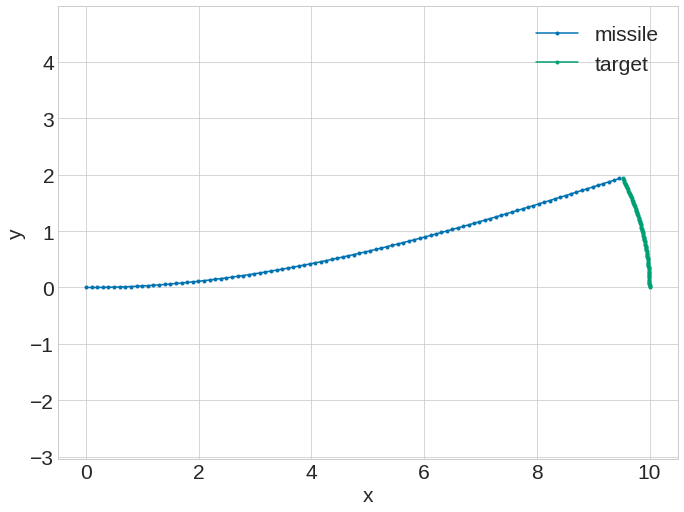

In [0]:
plt.plot(df.missile_x,df.missile_y,label='missile',marker='.')
plt.plot(df.target_x,df.target_y,label='target',marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.legend()
plt.plot()

[]

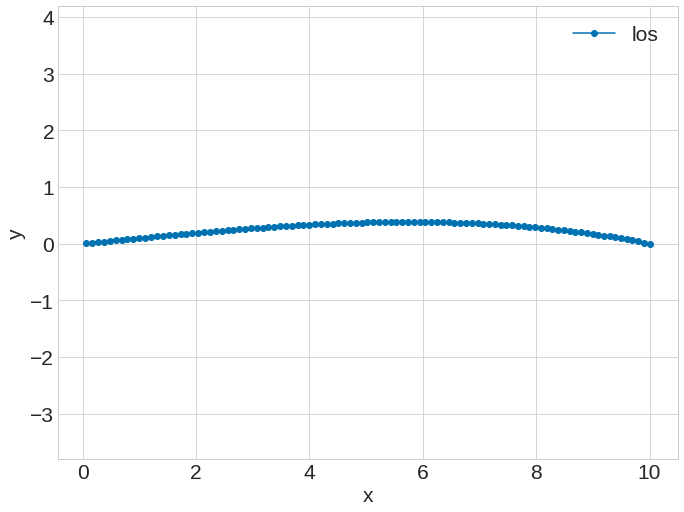

In [0]:
## Plot LOS
plt.plot(df.los_x,df.los_y,label='los',marker='o')
# plt.plot(df.target_x,df.target_y,label='target')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.legend()
plt.plot()

[]

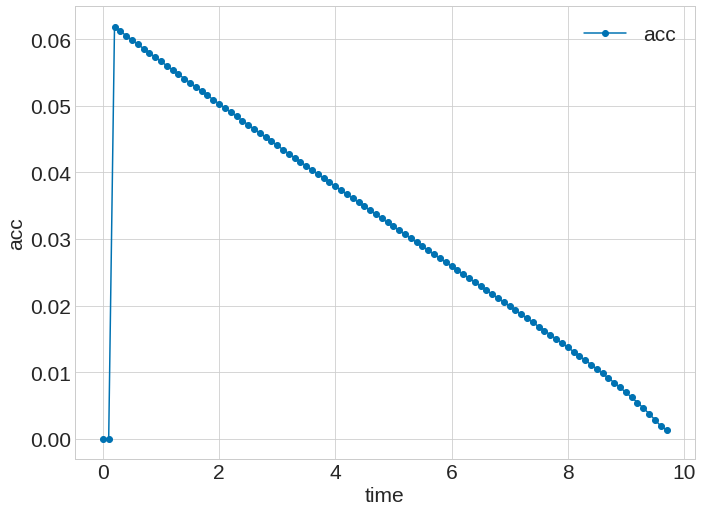

In [0]:
plt.plot(df.time,df.acc_norm,label='acc',marker='o')
plt.xlabel('time')
plt.ylabel('acc')
plt.legend()
plt.plot()

In [0]:
display(df)

,time,missile_x,missile_y,target_x,target_y,acc
0,0.0,0.000000,0.000000,10.00,0.00,0.000000
0,0.1,0.100000,0.100000,9.99,0.01,0.000000
0,0.2,0.196908,0.203092,9.98,0.02,0.437227
0,0.3,0.290463,0.309336,9.97,0.03,0.460285
0,0.4,0.380389,0.418775,9.96,0.04,0.483432
...,...,...,...,...,...,...
0,9.7,-5.585743,11.193773,9.03,0.97,0.053565
0,9.8,-5.688311,11.296781,9.02,0.98,0.051621
0,9.9,-5.791249,11.399421,9.01,0.99,0.052051
0,10.0,-5.893832,11.502417,9.00,1.00,0.050188


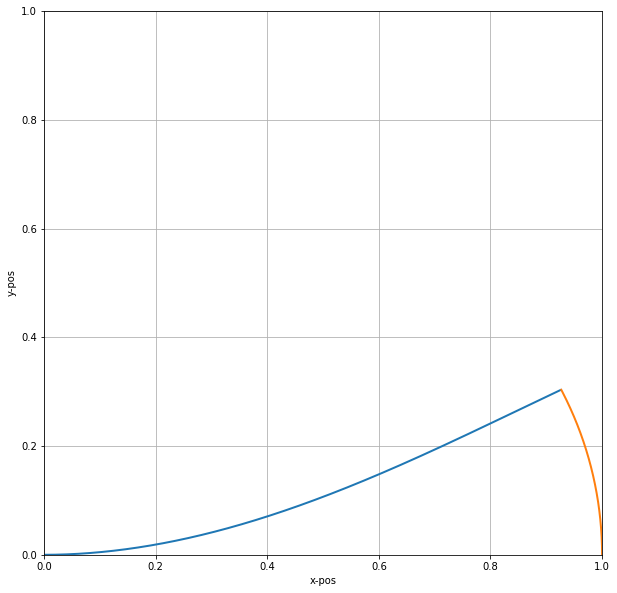

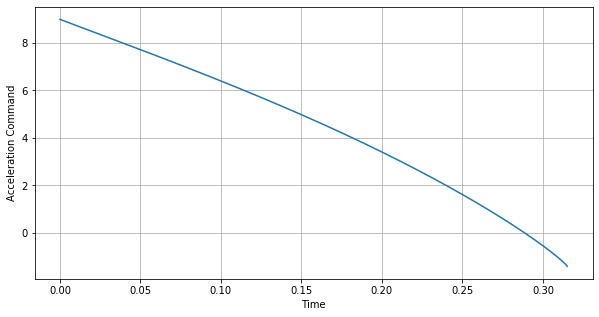

In [0]:
## source code of KOHEI

#Target Initial condition
vt0=1 #Target Velocity
gammat0=np.pi/2
xt=1
yt=0
nt=1.5
gammat=gammat0
vxt=vt0*np.cos(gammat)
vyt=vt0*np.sin(gammat)


#Missile Initial condition
v0=3 #Missile Velovity
gamma0=0
x=0
y=0
n=0
gamma=gamma0
vx=v0*np.cos(gamma)
vy=v0*np.sin(gamma)

t=0
h=0.00001

#For log
T=[]
Xt=[]
Yt=[]
X=[]
Y=[]
N=[]


#rtmx=xt-x
#rtmy=yt-y
#lambdaa=np.arctan2(rtmy, rtmx)


#Initial LOS angle and LOS rate
rtmx=xt-x
rtmy=yt-y
rtm=np.sqrt(rtmx**2+rtmy**2)
vtmx=vxt-vx # relative velocity
vtmy=vyt-vy

## 元記事ではミサイルとターゲットの近く速度(相対速度)となっているが，この式はは相対ベクトルではない
## Vc = - ( LOS \cdot \dot{LOS} ) / |LOS|^2
vc=-(rtmx*vtmx+rtmy*vtmy)/rtm 
lambdaa=np.arctan2(rtmy, rtmx)
lambdadot=(rtmx*vtmy-rtmy*vtmx)/rtm**2

#Initial navigation(m)

#PPN
#n=1000*(lambdaa-gamma)

#PN
n=3*vc*lambdadot


for i in range(500000):
    T.append(t)
    Xt.append(xt)
    Yt.append(yt)
    X.append(x)
    Y.append(y)
    N.append(n)
    
    #break
    if np.sqrt((x-xt)**2+(y-yt)**2)<0.001:
        break
    
    #Target
    #pos
    xt=xt+vxt*h
    yt=yt+vyt*h

    #velocity
    vxt=vt0*np.cos(gammat)
    vyt=vt0*np.sin(gammat)
    
    #angle
    gammadott=nt/vt0
    gammat=gammat+gammadott*h

    #Missile    
    #pos(m)
    x=x+vx*h
    y=y+vy*h

    #velocity(m)
    vx=vx-n*np.sin(lambdaa)*h
    vy=vy+n*np.cos(lambdaa)*h
    
    #angle(m)
    gamma=np.arctan2(vy, vx)

    #LOS angle and LOS rate
    rtmx=xt-x
    rtmy=yt-y
    rtm=np.sqrt(rtmx**2+rtmy**2)
    vtmx=vxt-vx
    vtmy=vyt-vy
    
    vc=-(rtmx*vtmx+rtmy*vtmy)/rtm
    lambdaa=np.arctan2(rtmy, rtmx)
    lambdadot=(rtmx*vtmy-rtmy*vtmx)/rtm**2

    #navigation(m)
    
    #PPN
    #n=1000*(lambdaa-gamma)
    
    #PN
    n=3*vc*lambdadot
    
    #time
    t=t+h
    
plt.figure(figsize=(10,10))
plt.plot(X, Y,lw=2)    
plt.plot(Xt, Yt, lw=2)
plt.xlabel('x-pos')
plt.ylabel('y-pos')
plt.xlim(0,1)
plt.ylim(0,1)


plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(T, N)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Acceleration Command')
plt.show()